In [1]:
import numpy as np

import pandas as pd
from pathlib import Path

import skimage.measure
import imagej

In [2]:
home = Path('R:/home')
top_dir = Path('R:/home/firefly_link/cancer')
save_dir = Path(top_dir, "analysis", "full")
df = pd.read_csv(
    Path(
        save_dir,
        "long_acqs_20230329_HPC_labelled_complete_intermediate_files/long_acqs_20230329_HPC_labelled_complete_non_ttx_active_df_by_cell.csv",
    )
)
df.expt = [x[1:] if x[0] == 'L' else x for x in df.expt]


df["exp_stage"] = df.expt + "_" + df.stage
event_df = df[(df.integrated_events != 0) & (df.obs_length == 4999)]

trials = event_df.trial.unique()
len(trials)
#print(event_df)

123

In [3]:
df = pd.read_csv(r'R:\home\firefly_link\cancer\analysis\correct_dataframes\long_acqs_20230329_HPC_labelled_complete.csv')
df.expt = [x[1:] if 'L' in x else x for x in df.expt]
df['exp_stage'] = df[['expt', 'stage']].fillna('none').agg('_'.join, axis=1)
df = df[df.date != 20230316]
df

,Unnamed: 0,Unnamed: 0.1,tif_file,SMR_file_0,multi_tif,date,slip,area,trial_string,ttx,high_k,n_frames,expt,stage,use,finish_at,exp_stage
0,0,109,/rds/general/user/ys5320/home/firefly_link/can...,/rds/general/user/ys5320/home/firefly_link/can...,1,20230302,1,1,cancer_20230302_slip1_area1_long_acq_cancer202...,False,False,10000,scratch,0h,y,NaN,scratch_0h
1,1,112,/rds/general/user/ys5320/home/firefly_link/can...,/rds/general/user/ys5320/home/firefly_link/can...,1,20230302,1,2,cancer_20230302_slip1_area2_long_acq_cancer202...,False,False,10000,scratch,0h,y,NaN,scratch_0h
2,2,110,/rds/general/user/ys5320/home/firefly_link/can...,/rds/general/user/ys5320/home/firefly_link/can...,1,20230302,1,3,cancer_20230302_slip1_area3_long_acq_cancer202...,False,False,10000,scratch,0h,y,NaN,scratch_0h
3,3,118,/rds/general/user/ys5320/home/firefly_link/can...,/rds/general/user/ys5320/home/firefly_link/can...,1,20230302,1,4,cancer_20230302_slip1_area4_long_acq_cancer202...,False,False,10000,scratch,0h,y,NaN,scratch_0h
4,4,115,/rds/general/user/ys5320/home/firefly_link/can...,/rds/general/user/ys5320/home/firefly_link/can...,1,20230302,1,5,cancer_20230302_slip1_area5_long_acq_cancer202...,False,False,10000,inner,0h,y,NaN,inner_0h
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,144,228,/rds/general/user/ys5320/home/firefly_link/can...,/rds/general/user/ys5320/home/firefly_link/can...,1,20230324,2,2,cancer_20230324_slip2_area2_long_acq_cancer202...,False,False,10000,scratch,6h,y,NaN,scratch_6h
145,145,227,/rds/general/user/ys5320/home/firefly_link/can...,/rds/general/user/ys5320/home/firefly_link/can...,1,20230324,2,3,cancer_20230324_slip2_area3_long_acq_cancer202...,False,False,10000,scratch,6h,y,NaN,scratch_6h
146,146,235,/rds/general/user/ys5320/home/firefly_link/can...,/rds/general/user/ys5320/home/firefly_link/can...,1,20230324,2,4,cancer_20230324_slip2_area4_long_acq_cancer202...,False,False,10000,scratch,6h,y,NaN,scratch_6h
147,147,232,/rds/general/user/ys5320/home/firefly_link/can...,/rds/general/user/ys5320/home/firefly_link/can...,1,20230324,2,5,cancer_20230324_slip2_area5_long_acq_cancer202...,False,False,10000,inner,6h,y,NaN,inner_6h


In [33]:
for l in df.exp_stage.unique():
    
    print(l)
    l_df = df[df.exp_stage == l]
    results = pd.DataFrame(columns = ['exp_stage', 'trial', 'cell','area','circularity','roundness','solidity','aspect'])
    results_active = pd.DataFrame(columns = ['exp_stage', 'trial', 'cell','area','circularity','roundness','solidity','aspect'])
    for idx, data in enumerate(l_df.itertuples()):
            trial_string = data.trial_string
            trial_save = Path(save_dir, "ratio_stacks", trial_string)
            exp_stage = data.exp_stage

            eve = event_df[event_df.trial == trial_string]
            cells = []
            for data in eve.itertuples():
                cell = int(data.cell.split('_')[-1])
                cells.append(cell)

            seg = np.load(Path(trial_save, f"{trial_string}_seg.npy"))
            #print(seg.shape)

            props = skimage.measure.regionprops(seg)
            #print(len(props))

            di = {
                "cell": [],
                "area": [],
                'perimeter': [],
                "circularity": [],
                "roundness": [],
                "solidity": [],
                "aspect": [],
            }

            for idx, cell in enumerate(props):
                #print(idx, cell["eccentricity"])
                di["cell"].append(idx)
                di["area"].append(cell["area"])
                di["perimeter"].append(cell["perimeter"])
                di["solidity"].append(cell["solidity"])
                di["aspect"].append(cell["eccentricity"])
                di["circularity"].append(4 * np.pi * cell["area"] / cell["perimeter"] ** 2)
                di["roundness"].append( 4 * cell["area"] / (np.pi * cell["major_axis_length"]))
                

            di = pd.DataFrame(di)
            di.insert(0,'trial',trial_string)
            di.insert(0,'exp_stage',l)
            di_active = di.iloc[cells,:]
            #print(di)
            results = results.append(di, ignore_index = True)
            results_active = results_active.append(di_active, ignore_index =True)

    results_active.to_csv(Path(
                save_dir,
                "long_acqs_20230329_HPC_labelled_complete_intermediate_files",
                f"{l}_active_cell_morphologies.csv",
            )
        )
    print(results.shape)
    print(results_active.shape)
    '''
    results.to_csv(
            Path(
                save_dir,
                "cell_morphologies",
                f"{l}_all_cell_morphologies.csv",
            )
        )
    '''
    results_active.to_csv(
            Path(
                save_dir,
                "cell_morphologies",
                f"{l}_active_cell_morphologies.csv",
            )
        )

scratch_0h
      exp_stage                                              trial  cell  \
0    scratch_0h  cancer_20230302_slip1_area1_long_acq_cancer202...     0   
1    scratch_0h  cancer_20230302_slip1_area1_long_acq_cancer202...     1   
2    scratch_0h  cancer_20230302_slip1_area1_long_acq_cancer202...     2   
3    scratch_0h  cancer_20230302_slip1_area1_long_acq_cancer202...     3   
4    scratch_0h  cancer_20230302_slip1_area1_long_acq_cancer202...     4   
..          ...                                                ...   ...   
172  scratch_0h  cancer_20230302_slip1_area1_long_acq_cancer202...   172   
173  scratch_0h  cancer_20230302_slip1_area1_long_acq_cancer202...   173   
174  scratch_0h  cancer_20230302_slip1_area1_long_acq_cancer202...   174   
175  scratch_0h  cancer_20230302_slip1_area1_long_acq_cancer202...   175   
176  scratch_0h  cancer_20230302_slip1_area1_long_acq_cancer202...   176   

     area  perimeter  circularity  roundness  solidity    aspect  
0     524

      exp_stage                                              trial  cell  \
0    scratch_0h  cancer_20230302_slip2_area2_long_acq_cancer202...     0   
1    scratch_0h  cancer_20230302_slip2_area2_long_acq_cancer202...     1   
2    scratch_0h  cancer_20230302_slip2_area2_long_acq_cancer202...     2   
3    scratch_0h  cancer_20230302_slip2_area2_long_acq_cancer202...     3   
4    scratch_0h  cancer_20230302_slip2_area2_long_acq_cancer202...     4   
..          ...                                                ...   ...   
124  scratch_0h  cancer_20230302_slip2_area2_long_acq_cancer202...   124   
125  scratch_0h  cancer_20230302_slip2_area2_long_acq_cancer202...   125   
126  scratch_0h  cancer_20230302_slip2_area2_long_acq_cancer202...   126   
127  scratch_0h  cancer_20230302_slip2_area2_long_acq_cancer202...   127   
128  scratch_0h  cancer_20230302_slip2_area2_long_acq_cancer202...   128   

     area  perimeter  circularity  roundness  solidity    aspect  
0     290  74.426407

      exp_stage                                              trial  cell  \
0    scratch_0h  cancer_20230302_slip3_area3_long_acq_cancer202...     0   
1    scratch_0h  cancer_20230302_slip3_area3_long_acq_cancer202...     1   
2    scratch_0h  cancer_20230302_slip3_area3_long_acq_cancer202...     2   
3    scratch_0h  cancer_20230302_slip3_area3_long_acq_cancer202...     3   
4    scratch_0h  cancer_20230302_slip3_area3_long_acq_cancer202...     4   
..          ...                                                ...   ...   
115  scratch_0h  cancer_20230302_slip3_area3_long_acq_cancer202...   115   
116  scratch_0h  cancer_20230302_slip3_area3_long_acq_cancer202...   116   
117  scratch_0h  cancer_20230302_slip3_area3_long_acq_cancer202...   117   
118  scratch_0h  cancer_20230302_slip3_area3_long_acq_cancer202...   118   
119  scratch_0h  cancer_20230302_slip3_area3_long_acq_cancer202...   119   

     area  perimeter  circularity  roundness  solidity    aspect  
0      81  33.899495

      exp_stage                                              trial  cell  \
0    scratch_0h  cancer_20230310_slip1_area4_long_acq_cancer202...     0   
1    scratch_0h  cancer_20230310_slip1_area4_long_acq_cancer202...     1   
2    scratch_0h  cancer_20230310_slip1_area4_long_acq_cancer202...     2   
3    scratch_0h  cancer_20230310_slip1_area4_long_acq_cancer202...     3   
4    scratch_0h  cancer_20230310_slip1_area4_long_acq_cancer202...     4   
..          ...                                                ...   ...   
128  scratch_0h  cancer_20230310_slip1_area4_long_acq_cancer202...   128   
129  scratch_0h  cancer_20230310_slip1_area4_long_acq_cancer202...   129   
130  scratch_0h  cancer_20230310_slip1_area4_long_acq_cancer202...   130   
131  scratch_0h  cancer_20230310_slip1_area4_long_acq_cancer202...   131   
132  scratch_0h  cancer_20230310_slip1_area4_long_acq_cancer202...   132   

     area   perimeter  circularity  roundness  solidity    aspect  
0     174   53.7989

      exp_stage                                              trial  cell  \
0    scratch_0h  cancer_20230310_slip3_area1_long_acq_cancer202...     0   
1    scratch_0h  cancer_20230310_slip3_area1_long_acq_cancer202...     1   
2    scratch_0h  cancer_20230310_slip3_area1_long_acq_cancer202...     2   
3    scratch_0h  cancer_20230310_slip3_area1_long_acq_cancer202...     3   
4    scratch_0h  cancer_20230310_slip3_area1_long_acq_cancer202...     4   
..          ...                                                ...   ...   
157  scratch_0h  cancer_20230310_slip3_area1_long_acq_cancer202...   157   
158  scratch_0h  cancer_20230310_slip3_area1_long_acq_cancer202...   158   
159  scratch_0h  cancer_20230310_slip3_area1_long_acq_cancer202...   159   
160  scratch_0h  cancer_20230310_slip3_area1_long_acq_cancer202...   160   
161  scratch_0h  cancer_20230310_slip3_area1_long_acq_cancer202...   161   

     area  perimeter  circularity  roundness  solidity    aspect  
0      87  32.727922

      exp_stage                                              trial  cell  \
0    scratch_0h  cancer_20230322_slip1_area2_long_acq_cancer202...     0   
1    scratch_0h  cancer_20230322_slip1_area2_long_acq_cancer202...     1   
2    scratch_0h  cancer_20230322_slip1_area2_long_acq_cancer202...     2   
3    scratch_0h  cancer_20230322_slip1_area2_long_acq_cancer202...     3   
4    scratch_0h  cancer_20230322_slip1_area2_long_acq_cancer202...     4   
..          ...                                                ...   ...   
130  scratch_0h  cancer_20230322_slip1_area2_long_acq_cancer202...   130   
131  scratch_0h  cancer_20230322_slip1_area2_long_acq_cancer202...   131   
132  scratch_0h  cancer_20230322_slip1_area2_long_acq_cancer202...   132   
133  scratch_0h  cancer_20230322_slip1_area2_long_acq_cancer202...   133   
134  scratch_0h  cancer_20230322_slip1_area2_long_acq_cancer202...   134   

     area   perimeter  circularity  roundness  solidity    aspect  
0     262   57.4558

      exp_stage                                              trial  cell  \
0    scratch_0h  cancer_20230322_slip2_area3_long_acq_cancer202...     0   
1    scratch_0h  cancer_20230322_slip2_area3_long_acq_cancer202...     1   
2    scratch_0h  cancer_20230322_slip2_area3_long_acq_cancer202...     2   
3    scratch_0h  cancer_20230322_slip2_area3_long_acq_cancer202...     3   
4    scratch_0h  cancer_20230322_slip2_area3_long_acq_cancer202...     4   
..          ...                                                ...   ...   
111  scratch_0h  cancer_20230322_slip2_area3_long_acq_cancer202...   111   
112  scratch_0h  cancer_20230322_slip2_area3_long_acq_cancer202...   112   
113  scratch_0h  cancer_20230322_slip2_area3_long_acq_cancer202...   113   
114  scratch_0h  cancer_20230322_slip2_area3_long_acq_cancer202...   114   
115  scratch_0h  cancer_20230322_slip2_area3_long_acq_cancer202...   115   

     area   perimeter  circularity  roundness  solidity    aspect  
0    1464  170.9533

      exp_stage                                              trial  cell  \
0    scratch_0h  cancer_20230323_slip1_area4_long_acq_cancer202...     0   
1    scratch_0h  cancer_20230323_slip1_area4_long_acq_cancer202...     1   
2    scratch_0h  cancer_20230323_slip1_area4_long_acq_cancer202...     2   
3    scratch_0h  cancer_20230323_slip1_area4_long_acq_cancer202...     3   
4    scratch_0h  cancer_20230323_slip1_area4_long_acq_cancer202...     4   
..          ...                                                ...   ...   
164  scratch_0h  cancer_20230323_slip1_area4_long_acq_cancer202...   164   
165  scratch_0h  cancer_20230323_slip1_area4_long_acq_cancer202...   165   
166  scratch_0h  cancer_20230323_slip1_area4_long_acq_cancer202...   166   
167  scratch_0h  cancer_20230323_slip1_area4_long_acq_cancer202...   167   
168  scratch_0h  cancer_20230323_slip1_area4_long_acq_cancer202...   168   

     area   perimeter  circularity  roundness  solidity    aspect  
0     395   74.1837

      exp_stage                                              trial  cell  \
0    scratch_0h  cancer_20230324_slip1_area1_long_acq_cancer202...     0   
1    scratch_0h  cancer_20230324_slip1_area1_long_acq_cancer202...     1   
2    scratch_0h  cancer_20230324_slip1_area1_long_acq_cancer202...     2   
3    scratch_0h  cancer_20230324_slip1_area1_long_acq_cancer202...     3   
4    scratch_0h  cancer_20230324_slip1_area1_long_acq_cancer202...     4   
..          ...                                                ...   ...   
114  scratch_0h  cancer_20230324_slip1_area1_long_acq_cancer202...   114   
115  scratch_0h  cancer_20230324_slip1_area1_long_acq_cancer202...   115   
116  scratch_0h  cancer_20230324_slip1_area1_long_acq_cancer202...   116   
117  scratch_0h  cancer_20230324_slip1_area1_long_acq_cancer202...   117   
118  scratch_0h  cancer_20230324_slip1_area1_long_acq_cancer202...   118   

     area  perimeter  circularity  roundness  solidity    aspect  
0     186  48.970563

    exp_stage                                              trial  cell  area  \
0    inner_0h  cancer_20230302_slip1_area6_long_acq_cancer202...     0   408   
1    inner_0h  cancer_20230302_slip1_area6_long_acq_cancer202...     1   171   
2    inner_0h  cancer_20230302_slip1_area6_long_acq_cancer202...     2   126   
3    inner_0h  cancer_20230302_slip1_area6_long_acq_cancer202...     3   265   
4    inner_0h  cancer_20230302_slip1_area6_long_acq_cancer202...     4   266   
..        ...                                                ...   ...   ...   
220  inner_0h  cancer_20230302_slip1_area6_long_acq_cancer202...   220   266   
221  inner_0h  cancer_20230302_slip1_area6_long_acq_cancer202...   221   275   
222  inner_0h  cancer_20230302_slip1_area6_long_acq_cancer202...   222   250   
223  inner_0h  cancer_20230302_slip1_area6_long_acq_cancer202...   223   198   
224  inner_0h  cancer_20230302_slip1_area6_long_acq_cancer202...   224   331   

     perimeter  circularity  roundness 

    exp_stage                                              trial  cell  area  \
0    inner_0h  cancer_20230310_slip1_area5_long_acq_cancer202...     0   117   
1    inner_0h  cancer_20230310_slip1_area5_long_acq_cancer202...     1   233   
2    inner_0h  cancer_20230310_slip1_area5_long_acq_cancer202...     2   540   
3    inner_0h  cancer_20230310_slip1_area5_long_acq_cancer202...     3   331   
4    inner_0h  cancer_20230310_slip1_area5_long_acq_cancer202...     4   490   
..        ...                                                ...   ...   ...   
186  inner_0h  cancer_20230310_slip1_area5_long_acq_cancer202...   186   564   
187  inner_0h  cancer_20230310_slip1_area5_long_acq_cancer202...   187   288   
188  inner_0h  cancer_20230310_slip1_area5_long_acq_cancer202...   188   651   
189  inner_0h  cancer_20230310_slip1_area5_long_acq_cancer202...   189   308   
190  inner_0h  cancer_20230310_slip1_area5_long_acq_cancer202...   190   340   

      perimeter  circularity  roundness

    exp_stage                                              trial  cell  area  \
0    inner_0h  cancer_20230310_slip3_area6_long_acq_cancer202...     0   251   
1    inner_0h  cancer_20230310_slip3_area6_long_acq_cancer202...     1   191   
2    inner_0h  cancer_20230310_slip3_area6_long_acq_cancer202...     2   753   
3    inner_0h  cancer_20230310_slip3_area6_long_acq_cancer202...     3   304   
4    inner_0h  cancer_20230310_slip3_area6_long_acq_cancer202...     4   357   
..        ...                                                ...   ...   ...   
234  inner_0h  cancer_20230310_slip3_area6_long_acq_cancer202...   234   461   
235  inner_0h  cancer_20230310_slip3_area6_long_acq_cancer202...   235   236   
236  inner_0h  cancer_20230310_slip3_area6_long_acq_cancer202...   236   321   
237  inner_0h  cancer_20230310_slip3_area6_long_acq_cancer202...   237   125   
238  inner_0h  cancer_20230310_slip3_area6_long_acq_cancer202...   238    71   

      perimeter  circularity  roundness

    exp_stage                                              trial  cell  area  \
0    inner_0h  cancer_20230323_slip1_area5_long_acq_cancer202...     0   309   
1    inner_0h  cancer_20230323_slip1_area5_long_acq_cancer202...     1   519   
2    inner_0h  cancer_20230323_slip1_area5_long_acq_cancer202...     2   234   
3    inner_0h  cancer_20230323_slip1_area5_long_acq_cancer202...     3   464   
4    inner_0h  cancer_20230323_slip1_area5_long_acq_cancer202...     4   451   
..        ...                                                ...   ...   ...   
224  inner_0h  cancer_20230323_slip1_area5_long_acq_cancer202...   224   436   
225  inner_0h  cancer_20230323_slip1_area5_long_acq_cancer202...   225   262   
226  inner_0h  cancer_20230323_slip1_area5_long_acq_cancer202...   226   178   
227  inner_0h  cancer_20230323_slip1_area5_long_acq_cancer202...   227   148   
228  inner_0h  cancer_20230323_slip1_area5_long_acq_cancer202...   228   231   

     perimeter  circularity  roundness 

    exp_stage                                              trial  cell  area  \
0    inner_0h  cancer_20230324_slip1_area6_long_acq_cancer202...     0   160   
1    inner_0h  cancer_20230324_slip1_area6_long_acq_cancer202...     1   281   
2    inner_0h  cancer_20230324_slip1_area6_long_acq_cancer202...     2   484   
3    inner_0h  cancer_20230324_slip1_area6_long_acq_cancer202...     3   344   
4    inner_0h  cancer_20230324_slip1_area6_long_acq_cancer202...     4   326   
..        ...                                                ...   ...   ...   
181  inner_0h  cancer_20230324_slip1_area6_long_acq_cancer202...   181   674   
182  inner_0h  cancer_20230324_slip1_area6_long_acq_cancer202...   182   277   
183  inner_0h  cancer_20230324_slip1_area6_long_acq_cancer202...   183   470   
184  inner_0h  cancer_20230324_slip1_area6_long_acq_cancer202...   184   489   
185  inner_0h  cancer_20230324_slip1_area6_long_acq_cancer202...   185   115   

      perimeter  circularity  roundness

      exp_stage                                              trial  cell  \
0   scratch_24h  cancer_20230303_slip2_area1_long_acq_cancer202...     0   
1   scratch_24h  cancer_20230303_slip2_area1_long_acq_cancer202...     1   
2   scratch_24h  cancer_20230303_slip2_area1_long_acq_cancer202...     2   
3   scratch_24h  cancer_20230303_slip2_area1_long_acq_cancer202...     3   
4   scratch_24h  cancer_20230303_slip2_area1_long_acq_cancer202...     4   
..          ...                                                ...   ...   
80  scratch_24h  cancer_20230303_slip2_area1_long_acq_cancer202...    80   
81  scratch_24h  cancer_20230303_slip2_area1_long_acq_cancer202...    81   
82  scratch_24h  cancer_20230303_slip2_area1_long_acq_cancer202...    82   
83  scratch_24h  cancer_20230303_slip2_area1_long_acq_cancer202...    83   
84  scratch_24h  cancer_20230303_slip2_area1_long_acq_cancer202...    84   

    area   perimeter  circularity  roundness  solidity    aspect  
0     39   26.899495

      exp_stage                                              trial  cell  \
0   scratch_24h  cancer_20230303_slip3_area2_long_acq_cancer202...     0   
1   scratch_24h  cancer_20230303_slip3_area2_long_acq_cancer202...     1   
2   scratch_24h  cancer_20230303_slip3_area2_long_acq_cancer202...     2   
3   scratch_24h  cancer_20230303_slip3_area2_long_acq_cancer202...     3   
4   scratch_24h  cancer_20230303_slip3_area2_long_acq_cancer202...     4   
..          ...                                                ...   ...   
64  scratch_24h  cancer_20230303_slip3_area2_long_acq_cancer202...    64   
65  scratch_24h  cancer_20230303_slip3_area2_long_acq_cancer202...    65   
66  scratch_24h  cancer_20230303_slip3_area2_long_acq_cancer202...    66   
67  scratch_24h  cancer_20230303_slip3_area2_long_acq_cancer202...    67   
68  scratch_24h  cancer_20230303_slip3_area2_long_acq_cancer202...    68   

    area  perimeter  circularity  roundness  solidity    aspect  
0    232  62.769553  

     exp_stage                                              trial  cell  area  \
0    inner_24h  cancer_20230303_slip2_area5_long_acq_cancer202...     0   150   
1    inner_24h  cancer_20230303_slip2_area5_long_acq_cancer202...     1   145   
2    inner_24h  cancer_20230303_slip2_area5_long_acq_cancer202...     2   102   
3    inner_24h  cancer_20230303_slip2_area5_long_acq_cancer202...     3   200   
4    inner_24h  cancer_20230303_slip2_area5_long_acq_cancer202...     4   268   
..         ...                                                ...   ...   ...   
137  inner_24h  cancer_20230303_slip2_area5_long_acq_cancer202...   137   145   
138  inner_24h  cancer_20230303_slip2_area5_long_acq_cancer202...   138   176   
139  inner_24h  cancer_20230303_slip2_area5_long_acq_cancer202...   139   256   
140  inner_24h  cancer_20230303_slip2_area5_long_acq_cancer202...   140   211   
141  inner_24h  cancer_20230303_slip2_area5_long_acq_cancer202...   141   190   

     perimeter  circularity

       exp_stage                                              trial  cell  \
0    scratch_12h  cancer_20230311_slip1_area2_long_acq_cancer202...     0   
1    scratch_12h  cancer_20230311_slip1_area2_long_acq_cancer202...     1   
2    scratch_12h  cancer_20230311_slip1_area2_long_acq_cancer202...     2   
3    scratch_12h  cancer_20230311_slip1_area2_long_acq_cancer202...     3   
4    scratch_12h  cancer_20230311_slip1_area2_long_acq_cancer202...     4   
..           ...                                                ...   ...   
127  scratch_12h  cancer_20230311_slip1_area2_long_acq_cancer202...   127   
128  scratch_12h  cancer_20230311_slip1_area2_long_acq_cancer202...   128   
129  scratch_12h  cancer_20230311_slip1_area2_long_acq_cancer202...   129   
130  scratch_12h  cancer_20230311_slip1_area2_long_acq_cancer202...   130   
131  scratch_12h  cancer_20230311_slip1_area2_long_acq_cancer202...   131   

     area   perimeter  circularity  roundness  solidity    aspect  
0     3

       exp_stage                                              trial  cell  \
0    scratch_12h  cancer_20230311_slip2_area3_long_acq_cancer202...     0   
1    scratch_12h  cancer_20230311_slip2_area3_long_acq_cancer202...     1   
2    scratch_12h  cancer_20230311_slip2_area3_long_acq_cancer202...     2   
3    scratch_12h  cancer_20230311_slip2_area3_long_acq_cancer202...     3   
4    scratch_12h  cancer_20230311_slip2_area3_long_acq_cancer202...     4   
..           ...                                                ...   ...   
166  scratch_12h  cancer_20230311_slip2_area3_long_acq_cancer202...   166   
167  scratch_12h  cancer_20230311_slip2_area3_long_acq_cancer202...   167   
168  scratch_12h  cancer_20230311_slip2_area3_long_acq_cancer202...   168   
169  scratch_12h  cancer_20230311_slip2_area3_long_acq_cancer202...   169   
170  scratch_12h  cancer_20230311_slip2_area3_long_acq_cancer202...   170   

     area   perimeter  circularity  roundness  solidity    aspect  
0     2

     exp_stage                                              trial  cell  area  \
0    inner_12h  cancer_20230311_slip2_area6_long_acq_cancer202...     0   110   
1    inner_12h  cancer_20230311_slip2_area6_long_acq_cancer202...     1   225   
2    inner_12h  cancer_20230311_slip2_area6_long_acq_cancer202...     2    85   
3    inner_12h  cancer_20230311_slip2_area6_long_acq_cancer202...     3   209   
4    inner_12h  cancer_20230311_slip2_area6_long_acq_cancer202...     4   220   
..         ...                                                ...   ...   ...   
250  inner_12h  cancer_20230311_slip2_area6_long_acq_cancer202...   250   555   
251  inner_12h  cancer_20230311_slip2_area6_long_acq_cancer202...   251   391   
252  inner_12h  cancer_20230311_slip2_area6_long_acq_cancer202...   252   309   
253  inner_12h  cancer_20230311_slip2_area6_long_acq_cancer202...   253   144   
254  inner_12h  cancer_20230311_slip2_area6_long_acq_cancer202...   254   173   

      perimeter  circularit

      exp_stage                                              trial  cell  \
0    scratch_6h  cancer_20230322_slip4_area1_long_acq_cancer202...     0   
1    scratch_6h  cancer_20230322_slip4_area1_long_acq_cancer202...     1   
2    scratch_6h  cancer_20230322_slip4_area1_long_acq_cancer202...     2   
3    scratch_6h  cancer_20230322_slip4_area1_long_acq_cancer202...     3   
4    scratch_6h  cancer_20230322_slip4_area1_long_acq_cancer202...     4   
..          ...                                                ...   ...   
153  scratch_6h  cancer_20230322_slip4_area1_long_acq_cancer202...   153   
154  scratch_6h  cancer_20230322_slip4_area1_long_acq_cancer202...   154   
155  scratch_6h  cancer_20230322_slip4_area1_long_acq_cancer202...   155   
156  scratch_6h  cancer_20230322_slip4_area1_long_acq_cancer202...   156   
157  scratch_6h  cancer_20230322_slip4_area1_long_acq_cancer202...   157   

     area   perimeter  circularity  roundness  solidity    aspect  
0     151   46.1421

      exp_stage                                              trial  cell  \
0    scratch_6h  cancer_20230323_slip3_area2_long_acq_cancer202...     0   
1    scratch_6h  cancer_20230323_slip3_area2_long_acq_cancer202...     1   
2    scratch_6h  cancer_20230323_slip3_area2_long_acq_cancer202...     2   
3    scratch_6h  cancer_20230323_slip3_area2_long_acq_cancer202...     3   
4    scratch_6h  cancer_20230323_slip3_area2_long_acq_cancer202...     4   
..          ...                                                ...   ...   
168  scratch_6h  cancer_20230323_slip3_area2_long_acq_cancer202...   168   
169  scratch_6h  cancer_20230323_slip3_area2_long_acq_cancer202...   169   
170  scratch_6h  cancer_20230323_slip3_area2_long_acq_cancer202...   170   
171  scratch_6h  cancer_20230323_slip3_area2_long_acq_cancer202...   171   
172  scratch_6h  cancer_20230323_slip3_area2_long_acq_cancer202...   172   

     area   perimeter  circularity  roundness  solidity    aspect  
0     175   48.3847

      exp_stage                                              trial  cell  \
0    scratch_6h  cancer_20230323_slip4_area3_long_acq_cancer202...     0   
1    scratch_6h  cancer_20230323_slip4_area3_long_acq_cancer202...     1   
2    scratch_6h  cancer_20230323_slip4_area3_long_acq_cancer202...     2   
3    scratch_6h  cancer_20230323_slip4_area3_long_acq_cancer202...     3   
4    scratch_6h  cancer_20230323_slip4_area3_long_acq_cancer202...     4   
..          ...                                                ...   ...   
105  scratch_6h  cancer_20230323_slip4_area3_long_acq_cancer202...   105   
106  scratch_6h  cancer_20230323_slip4_area3_long_acq_cancer202...   106   
107  scratch_6h  cancer_20230323_slip4_area3_long_acq_cancer202...   107   
108  scratch_6h  cancer_20230323_slip4_area3_long_acq_cancer202...   108   
109  scratch_6h  cancer_20230323_slip4_area3_long_acq_cancer202...   109   

     area   perimeter  circularity  roundness  solidity    aspect  
0     580   95.3553

      exp_stage                                              trial  cell  \
0    scratch_6h  cancer_20230323_slip5_area4_long_acq_cancer202...     0   
1    scratch_6h  cancer_20230323_slip5_area4_long_acq_cancer202...     1   
2    scratch_6h  cancer_20230323_slip5_area4_long_acq_cancer202...     2   
3    scratch_6h  cancer_20230323_slip5_area4_long_acq_cancer202...     3   
4    scratch_6h  cancer_20230323_slip5_area4_long_acq_cancer202...     4   
..          ...                                                ...   ...   
111  scratch_6h  cancer_20230323_slip5_area4_long_acq_cancer202...   111   
112  scratch_6h  cancer_20230323_slip5_area4_long_acq_cancer202...   112   
113  scratch_6h  cancer_20230323_slip5_area4_long_acq_cancer202...   113   
114  scratch_6h  cancer_20230323_slip5_area4_long_acq_cancer202...   114   
115  scratch_6h  cancer_20230323_slip5_area4_long_acq_cancer202...   115   

     area   perimeter  circularity  roundness  solidity    aspect  
0     295   65.3553

inner_6h
    exp_stage                                              trial  cell  area  \
0    inner_6h  cancer_20230322_slip3_area5_long_acq_cancer202...     0   878   
1    inner_6h  cancer_20230322_slip3_area5_long_acq_cancer202...     1   762   
2    inner_6h  cancer_20230322_slip3_area5_long_acq_cancer202...     2   296   
3    inner_6h  cancer_20230322_slip3_area5_long_acq_cancer202...     3  1174   
4    inner_6h  cancer_20230322_slip3_area5_long_acq_cancer202...     4   377   
..        ...                                                ...   ...   ...   
153  inner_6h  cancer_20230322_slip3_area5_long_acq_cancer202...   153   268   
154  inner_6h  cancer_20230322_slip3_area5_long_acq_cancer202...   154   330   
155  inner_6h  cancer_20230322_slip3_area5_long_acq_cancer202...   155   231   
156  inner_6h  cancer_20230322_slip3_area5_long_acq_cancer202...   156   237   
157  inner_6h  cancer_20230322_slip3_area5_long_acq_cancer202...   157   217   

      perimeter  circularity  

    exp_stage                                              trial  cell  area  \
0    inner_6h  cancer_20230323_slip3_area6_long_acq_cancer202...     0   455   
1    inner_6h  cancer_20230323_slip3_area6_long_acq_cancer202...     1   690   
2    inner_6h  cancer_20230323_slip3_area6_long_acq_cancer202...     2   386   
3    inner_6h  cancer_20230323_slip3_area6_long_acq_cancer202...     3   655   
4    inner_6h  cancer_20230323_slip3_area6_long_acq_cancer202...     4   661   
..        ...                                                ...   ...   ...   
154  inner_6h  cancer_20230323_slip3_area6_long_acq_cancer202...   154   720   
155  inner_6h  cancer_20230323_slip3_area6_long_acq_cancer202...   155   459   
156  inner_6h  cancer_20230323_slip3_area6_long_acq_cancer202...   156   241   
157  inner_6h  cancer_20230323_slip3_area6_long_acq_cancer202...   157   210   
158  inner_6h  cancer_20230323_slip3_area6_long_acq_cancer202...   158   153   

      perimeter  circularity  roundness

    exp_stage                                              trial  cell  area  \
0    inner_6h  cancer_20230324_slip2_area5_long_acq_cancer202...     0    72   
1    inner_6h  cancer_20230324_slip2_area5_long_acq_cancer202...     1   235   
2    inner_6h  cancer_20230324_slip2_area5_long_acq_cancer202...     2   421   
3    inner_6h  cancer_20230324_slip2_area5_long_acq_cancer202...     3   498   
4    inner_6h  cancer_20230324_slip2_area5_long_acq_cancer202...     4   381   
..        ...                                                ...   ...   ...   
210  inner_6h  cancer_20230324_slip2_area5_long_acq_cancer202...   210   578   
211  inner_6h  cancer_20230324_slip2_area5_long_acq_cancer202...   211   250   
212  inner_6h  cancer_20230324_slip2_area5_long_acq_cancer202...   212   215   
213  inner_6h  cancer_20230324_slip2_area5_long_acq_cancer202...   213   279   
214  inner_6h  cancer_20230324_slip2_area5_long_acq_cancer202...   214   106   

      perimeter  circularity  roundness

In [13]:
home = Path('R:/home')
top_dir = Path('R:/home/firefly_link/cancer')
save_dir = Path(top_dir, "analysis", "full")

df = pd.read_csv(r'R:\home\firefly_link\cancer\analysis\correct_dataframes\20220423_original_and_review.csv')
df.expt = [x[1:] if 'L' in x else x for x in df.expt]
df['exp_stage'] = df[['expt', 'stage']].fillna('none').agg('_'.join, axis=1)
event_df = pd.read_csv(
    Path(
        save_dir,
        "20220423_original_and_review_intermediate_files/20220423_original_and_review_non_ttx_active_df_by_cell.csv",
    )
)

event_df = event_df[(event_df.integrated_events != 0) & (event_df.obs_length == 4999)]

trials = event_df.trial.unique()

df.expt = [x[1:] if 'L' in x else x for x in df.expt]
df['exp_stage'] = df[['expt', 'stage']].fillna('none').agg('_'.join, axis=1)

MDA_keys = [
    "standard_none",
    "TTX_10um_pre",
    "TTX_10um_washout_pre",
    "TTX_1um_pre",
    "231_none",
]
TGFB_keys = [
    'MCF10A_TGFB_none',
    'MCF10A_TGFB_0314_none',
    'MCF10A_TGFB_0304_none'
]

df.exp_stage = [x if x not in MDA_keys and x not in TGFB_keys else "231_none" if x in MDA_keys else 'MCF10A_TGFB_none' for x in df.exp_stage]
#print(df.exp_stage.unique())
line_keys = ['MCF10A_none','MCF10A_TGFB_none',"231_none",'T47D_none','BT474_none','453_none','468_none','Cal51_none','SUM159_none','231_none','Hs578t_none']
df = df.loc[df.exp_stage.isin(line_keys)]
print(df.exp_stage.unique())


trials = event_df.trial.unique()
df = df[df.trial_string.isin(trials)]
df

['231_none' 'Hs578t_none' 'Cal51_none' 'SUM159_none' 'BT474_none'
 'T47D_none' '468_none' '453_none' 'MCF10A_none' 'MCF10A_TGFB_none']


,Unnamed: 0,Unnamed: 0.1,tif_file,multi_tif,date,slip,area,trial_string,ttx,high_k,...,SMR_file,media,notes,washin_idx,thresh_use,start,end,duration,checked,exp_stage
0,0,0,/rds/general/project/thefarm2/live/Firefly/can...,1,20220209,2,2,cancer_cancer20220209_slip2_area2_long_acq_202...,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y,231_none
1,1,1,/rds/general/project/thefarm2/live/Firefly/can...,1,20220209,2,3,cancer_cancer20220209_slip2_area3_long_acq_202...,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y,231_none
3,3,3,/rds/general/project/thefarm2/live/Firefly/can...,1,20220210,1,1,cancer_cancer20220210_slip1_area1_long_acq_202...,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y,231_none
4,4,4,/rds/general/project/thefarm2/live/Firefly/can...,1,20220210,1,2,cancer_cancer20220210_slip1_area2_long_acq_202...,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y,231_none
5,5,5,/rds/general/project/thefarm2/live/Firefly/can...,1,20220210,1,3,cancer_cancer20220210_slip1_area3_long_acq_202...,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y,231_none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,479,23,/rds/general/project/thefarm2/live/Firefly/can...,1,20220322,2,4,cancer_20220322_slip2_area4_long_acq_cancer202...,False,False,...,NaN,NaN,NaN,NaN,NaN,314.0,322.0,192.0,NaN,MCF10A_TGFB_none
485,485,29,/rds/general/project/thefarm2/live/Firefly/can...,1,20220328,2,2,cancer_20220328_slip2_area2_long_acq_cancer202...,False,False,...,NaN,NaN,NaN,NaN,NaN,304.0,328.0,576.0,NaN,MCF10A_TGFB_none
486,486,30,/rds/general/project/thefarm2/live/Firefly/can...,1,20220328,2,3,cancer_20220328_slip2_area3_long_acq_cancer202...,False,False,...,NaN,NaN,NaN,NaN,NaN,304.0,328.0,576.0,NaN,MCF10A_TGFB_none
496,496,40,/rds/general/project/thefarm2/live/Firefly/can...,1,20220329,1,1,cancer_20220329_slip1_area1_long_acq_cancer202...,False,False,...,NaN,NaN,NaN,NaN,NaN,304.0,329.0,600.0,NaN,MCF10A_TGFB_none


In [15]:
event_df

,Unnamed: 0,cell,trial,day,n_pos_events,n_neg_events,integrated_events,neg_integrated_events,slip,expt,stage,obs_length
57,57,cancer_cancer20220209_slip2_area2_long_acq_202...,cancer_cancer20220209_slip2_area2_long_acq_202...,20220209,1,0,0.128621,0.000000,2,L231,none,4999
102,102,cancer_cancer20220209_slip2_area2_long_acq_202...,cancer_cancer20220209_slip2_area2_long_acq_202...,20220209,1,0,0.093432,0.000000,2,L231,none,4999
148,148,cancer_cancer20220209_slip2_area2_long_acq_202...,cancer_cancer20220209_slip2_area2_long_acq_202...,20220209,1,1,0.280581,-0.126807,2,L231,none,4999
168,168,cancer_cancer20220209_slip2_area2_long_acq_202...,cancer_cancer20220209_slip2_area2_long_acq_202...,20220209,2,0,0.218533,0.000000,2,L231,none,4999
170,170,cancer_cancer20220209_slip2_area2_long_acq_202...,cancer_cancer20220209_slip2_area2_long_acq_202...,20220209,0,1,0.096181,-0.096181,2,L231,none,4999
...,...,...,...,...,...,...,...,...,...,...,...,...
44567,44567,cancer_20220329_slip1_area3_long_acq_cancer202...,cancer_20220329_slip1_area3_long_acq_cancer202...,20220329,0,1,0.038383,-0.038383,1,LMCF10A_TGFB_0304,none,4999
44573,44573,cancer_20220329_slip1_area3_long_acq_cancer202...,cancer_20220329_slip1_area3_long_acq_cancer202...,20220329,0,3,0.144448,-0.144448,1,LMCF10A_TGFB_0304,none,4999
44574,44574,cancer_20220329_slip1_area3_long_acq_cancer202...,cancer_20220329_slip1_area3_long_acq_cancer202...,20220329,0,1,0.069335,-0.069335,1,LMCF10A_TGFB_0304,none,4999
44575,44575,cancer_20220329_slip1_area3_long_acq_cancer202...,cancer_20220329_slip1_area3_long_acq_cancer202...,20220329,0,2,0.071765,-0.071765,1,LMCF10A_TGFB_0304,none,4999


In [30]:
for l in df.exp_stage.unique():
    print(l)
    l_df = df[df.exp_stage == l]
    print(l_df.shape[0])
    results = pd.DataFrame(columns = ['exp_stage', 'trial', 'cell','Ac','area','circularity','roundness','solidity','aspect'])
    results_active = pd.DataFrame(columns = ['exp_stage', 'trial', 'cell','Ac','area','circularity','roundness','solidity','aspect'])
    for idx, data in enumerate(l_df.itertuples()):
            trial_string = data.trial_string
            trial_save = Path(save_dir, "ratio_stacks", trial_string)
            exp_stage = data.exp_stage
            
            eve = event_df[event_df.trial == trial_string]
            cells = []
            for data in eve.itertuples():
                cell = int(data.cell.split('_')[-1])
                cells.append(cell)

            seg = np.load(Path(trial_save, f"{trial_string}_seg.npy"))

            props = skimage.measure.regionprops(seg)

            di = {
                "cell": [],
                'Ac': [],
                "area": [],
                'perimeter': [],
                "circularity": [],
                "roundness": [],
                "solidity": [],
                "aspect": [],
            }

            for idx, cell in enumerate(props):
                di["cell"].append(idx)
                di["area"].append(cell["area"])
                di["perimeter"].append(cell["perimeter"])
                di["circularity"].append(4 * np.pi * cell["area"] / cell["perimeter"] ** 2)
                di["roundness"].append(4 * cell["area"] / (np.pi * cell["major_axis_length"]))
                di["solidity"].append(cell["solidity"])
                di["aspect"].append(cell["eccentricity"])
                if idx in cells:
                    di['Ac'].append('active')
                else:
                    di['Ac'].append('inactive')
                    
            di = pd.DataFrame(di)
            di.insert(0,'trial',trial_string)
            di.insert(0,'exp_stage',l)
            di_active = di.iloc[cells,:]
            results = results.append(di, ignore_index = True)
            results_active = results_active.append(di_active, ignore_index =True)
    results_active.to_csv(Path(
                save_dir,
                "cell_morphologies",
                f"{l}_active_cell_morphologies.csv",
            )
        )
    print(results.shape)
    print(results_active.shape)
    results.to_csv(
            Path(
                save_dir,
                "cell_morphologies",
                f"{l}_all_cell_morphologies.csv",
            )
        )

231_none
28
(3755, 10)
(231, 10)
Hs578t_none
27
(2274, 10)
(71, 10)
SUM159_none
23
(2391, 10)
(57, 10)
Cal51_none
32
(9344, 10)
(128, 10)
BT474_none
33
(2143, 10)
(371, 10)
T47D_none
29
(1903, 10)
(155, 10)
468_none
26
(2988, 10)
(858, 10)
453_none
7
(114, 10)
(41, 10)
MCF10A_none
15
(2801, 10)
(30, 10)
MCF10A_TGFB_none
25
(2272, 10)
(50, 10)


In [4]:
morph_231 = pd.read_csv(Path(
                save_dir,
                "cell_morphologies",
                "231_none_all_cell_morphologies.csv"))
morph_231

,Unnamed: 0,exp_stage,trial,cell,Ac,area,circularity,roundness,solidity,aspect,perimeter
0,0,231_none,cancer_cancer20220209_slip2_area2_long_acq_202...,0,inactive,79,0.975594,7.972703,0.987500,0.755343,31.899495
1,1,231_none,cancer_cancer20220209_slip2_area2_long_acq_202...,1,inactive,288,0.737717,12.694436,0.947368,0.895429,70.041631
2,2,231_none,cancer_cancer20220209_slip2_area2_long_acq_202...,2,inactive,298,0.947411,16.780229,0.973856,0.656717,62.870058
3,3,231_none,cancer_cancer20220209_slip2_area2_long_acq_202...,3,inactive,326,0.872379,16.129436,0.953216,0.776073,68.526912
4,4,231_none,cancer_cancer20220209_slip2_area2_long_acq_202...,4,inactive,477,0.900263,20.200293,0.967546,0.739561,81.597980
...,...,...,...,...,...,...,...,...,...,...,...
3750,3750,231_none,cancer_20201229_slip4_area3_long_acq_corr_long...,43,inactive,678,0.701255,22.181949,0.927497,0.792757,110.225397
3751,3751,231_none,cancer_20201229_slip4_area3_long_acq_corr_long...,44,inactive,696,0.622129,19.502479,0.893453,0.890491,118.568542
3752,3752,231_none,cancer_20201229_slip4_area3_long_acq_corr_long...,45,inactive,578,0.666066,18.209901,0.936791,0.881793,104.426407
3753,3753,231_none,cancer_20201229_slip4_area3_long_acq_corr_long...,46,inactive,540,0.749457,18.269761,0.949033,0.869262,95.154329


roundness 0.025970706591840784


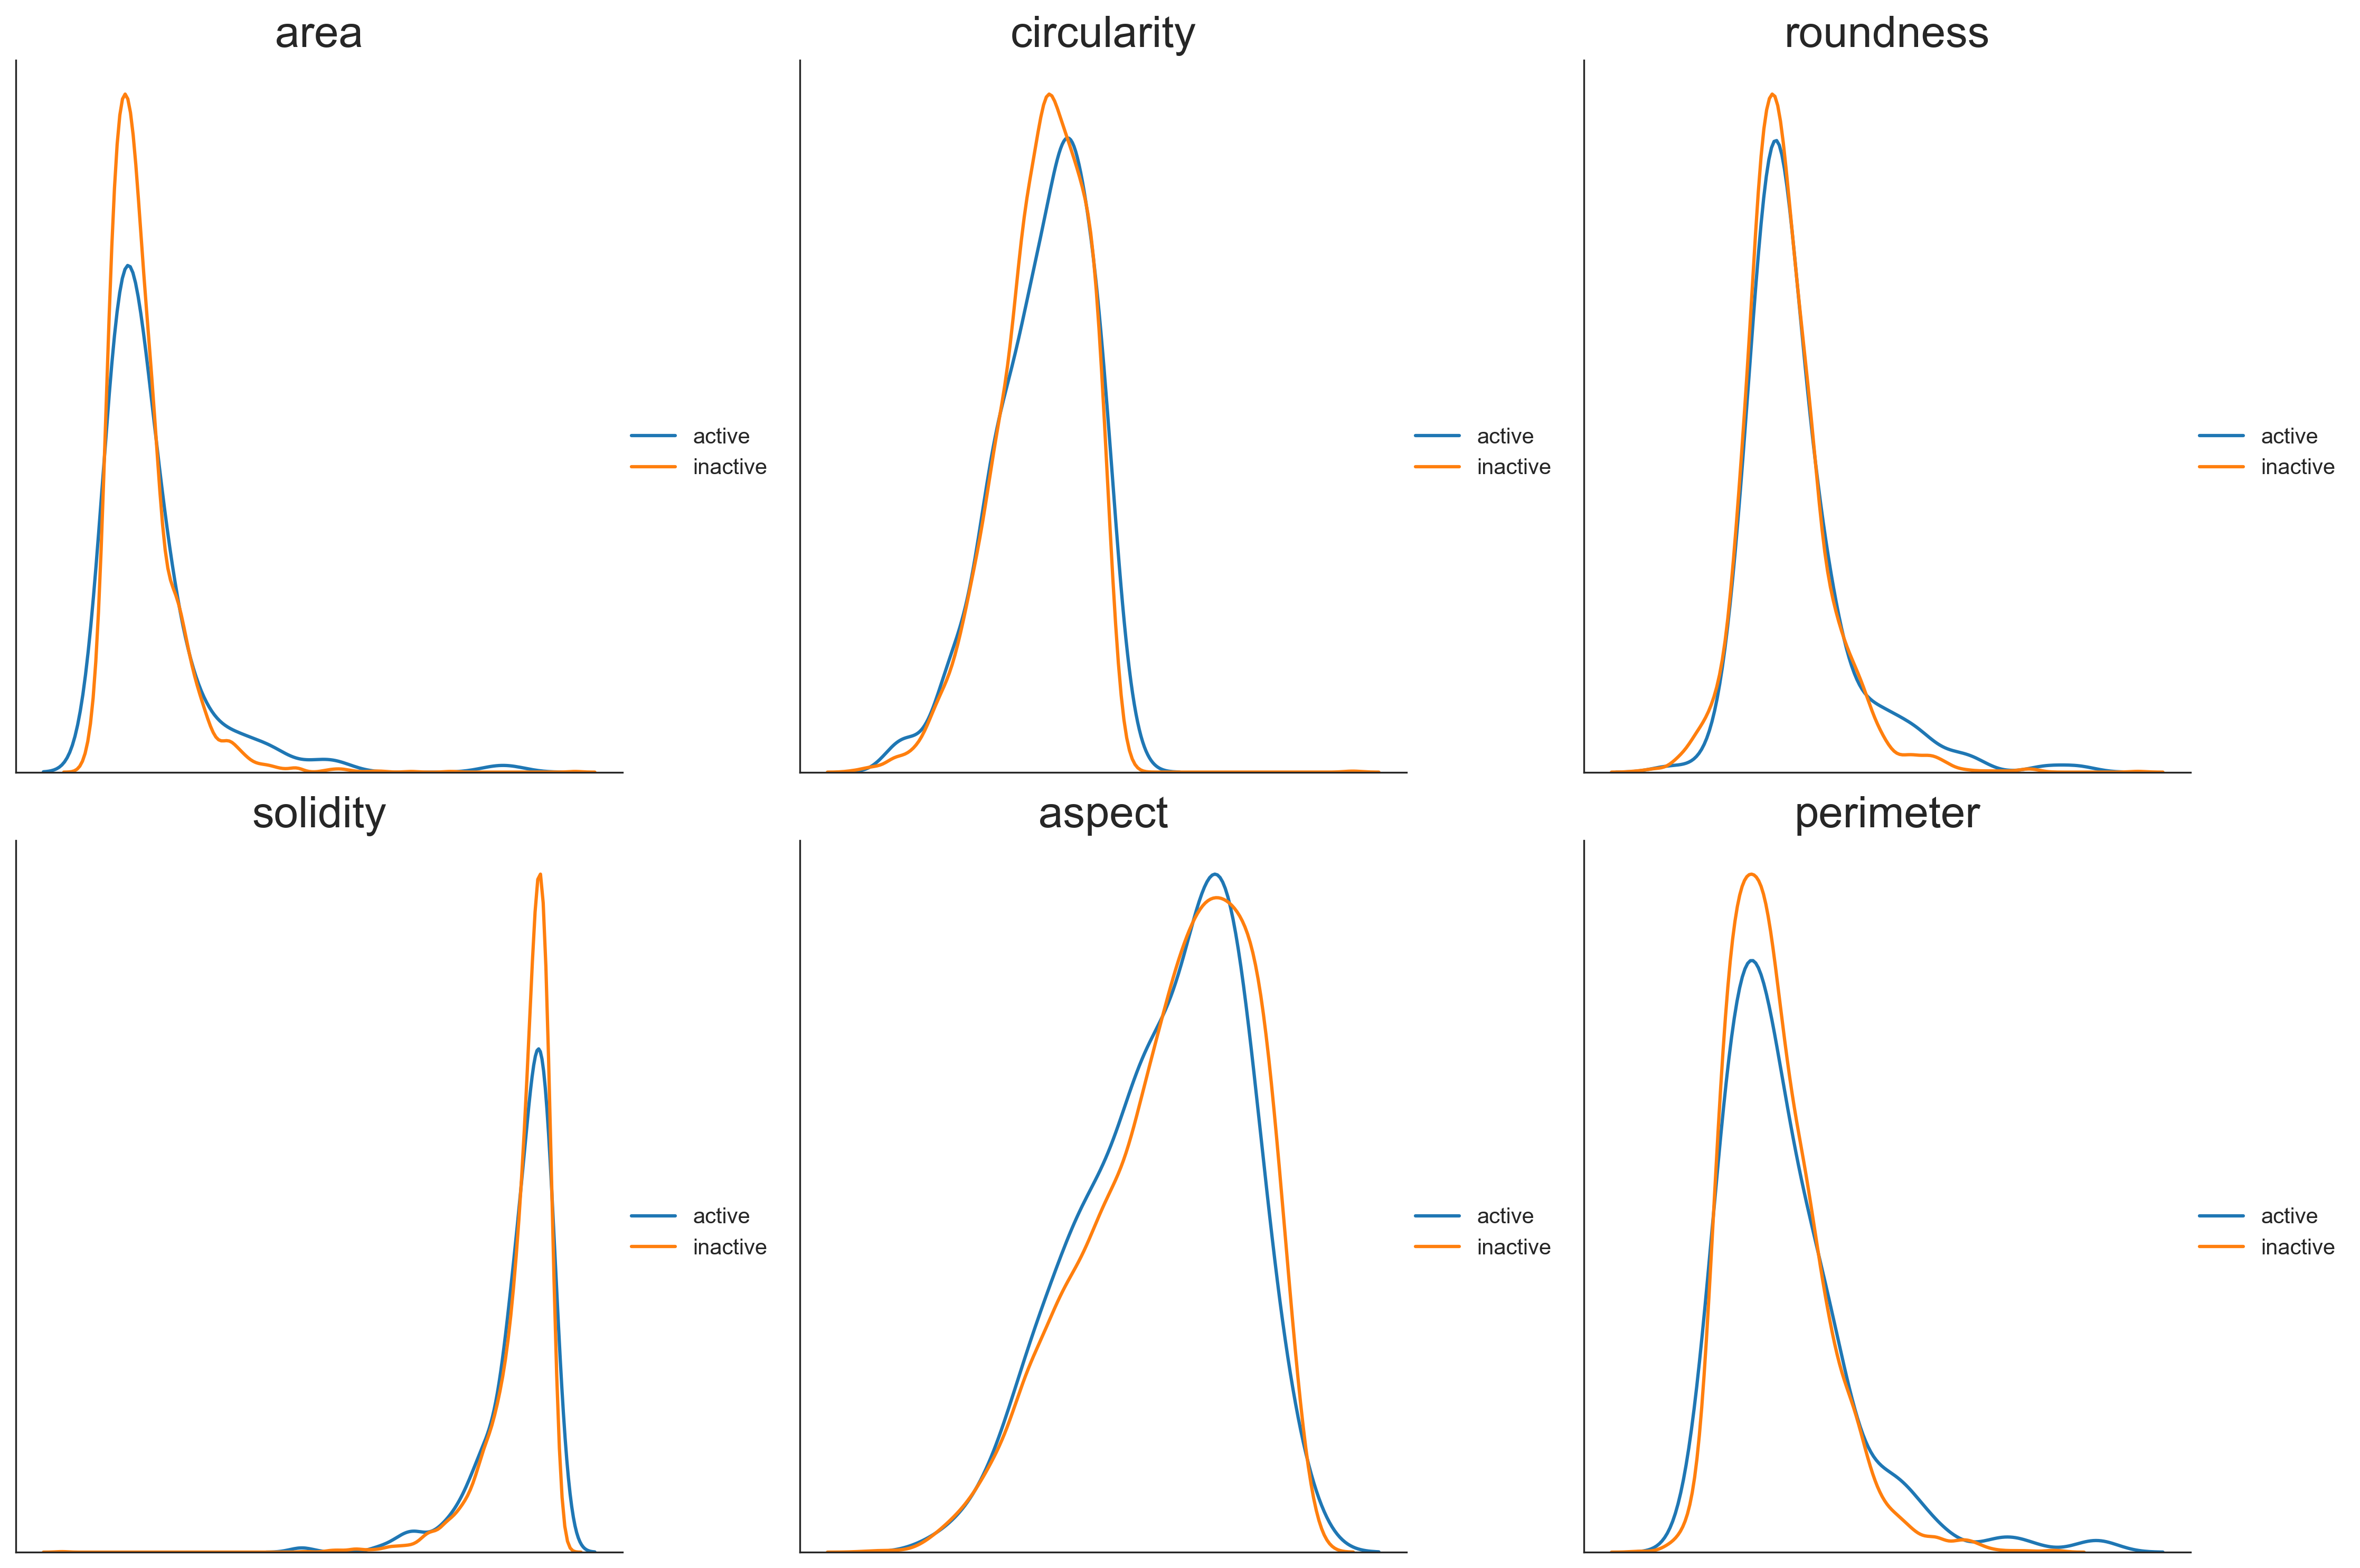

In [7]:
figure_save = Path(r'C:\Users\Firefly\Desktop\morphology_figure\231')
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
from vsd_cancer.functions import stats_functions as statsf

plt.figure(figsize=(15,10),dpi=300)
f = open(Path(figure_save,f"p_morph_231.txt"), "w")

for i in range(6):
    c = morph_231.columns[5+i]
    # Set up the plot
    plt.subplot(2, 3, i+1)
    scratch = morph_231[morph_231['Ac'] == 'active'].iloc[:,5+i]
    inner = morph_231[morph_231['Ac'] == 'inactive'].iloc[:,5+i]
    U1, p1 = mannwhitneyu(scratch, inner)
    p2 = statsf.bootstrap_test(morph_231[morph_231.Ac == "active"].iloc[:,5+i].to_numpy(), morph_231[morph_231.Ac == "inactive"].iloc[:,5+i].to_numpy())[0]
    #print(c,p1,p2)
    if p1 < 0.05:
        print(c,p1)
        f.write(c + ': ')
        f.write(str(p1) + '\n')
        f.write(f'active: {scratch.mean()}' + '\n')
        f.write(f'inactive: {inner.mean()}' + '\n')
    # Draw the plot
    sns.kdeplot(scratch,label = 'active')
    sns.kdeplot(inner,label = 'inactive')

    sns.despine(top=True, right=True, left=False, bottom=False)
    sns.set_style('white')
    # Title and labels
    plt.title(c,fontsize=20)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(None)
    plt.ylabel(None)
    plt.legend(loc=[1,0.4],frameon=False)

plt.tight_layout()
plt.savefig(Path(figure_save,f'Morph - distribution -231.png'))
plt.show()